In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import os
import sys
sys.path.append(os.path.abspath("../lib"))
from show import compare_repartition, histo_continuous

In [2]:
os.environ['PYSPARK_DRIVER_PYTHON_OPTS'] = "notebook"
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable
os.environ['PYSPARK_PYTHON'] = sys.executable

spark = SparkSession \
    .builder \
    .appName("renovation") \
    .getOrCreate()

# set this parameter for date issue before 1582 (dpe database)
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")

In [3]:
# import files
# File location and type
file_location_array = [
    {"location": "../training/pred_tremi_old.csv",
        "name": "pred_tremi_full", "delimiter": ","},
    {"location": "../training/dico.csv", "name": "dictionary", "delimiter": "\t"}
]
file_type = "csv"

# CSV options
infer_schema = "true"
first_row_is_header = "true"
dataframes = {}

# The applied options are for CSV files. For other file types, these will be ignored.
for file in file_location_array:
    delimiter = file["delimiter"]
    file_location = file["location"]
    name = file["name"]
    dataframes[file["name"]] = (
        spark.read.format(file_type)
        .option("inferSchema", infer_schema)
        .option("header", first_row_is_header)
        .option("sep", delimiter)
        .load(file_location)
    )

In [4]:
# name the important datasets and cast to type
training_tremi = (
    dataframes['pred_tremi_full'].withColumns({
        'surface': F.col('surface').cast('int'),
        'heating_production': F.col('heating_production').cast('int'),
        'heating_emission': F.col('heating_emission').cast('int')
    })
)

dictionary = dataframes['dictionary']

In [5]:
# split training and prediction datasets
training_surf = training_tremi.filter(F.col('surface').isNotNull()).drop(
    'heating_production', 'heating_emission')

training_prod = training_tremi.filter(
    F.col('heating_production').isNotNull()).drop('surface', 'heating_emission')

training_em = training_tremi.filter(
    F.col('heating_emission').isNotNull()).drop('surface', 'heating_production')

print(f"""
{training_surf.count() =}
{training_prod.count() =}
""")


training_surf.count() =12565
training_prod.count() =11128



# pred_Tremi

c:\Users\arocheteau\OneDrive - ASI\Documents\1_perso\projet\datalake\notebook\pySpark\lib\show.py:77: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['%1.2f%%' % i for i in vals])


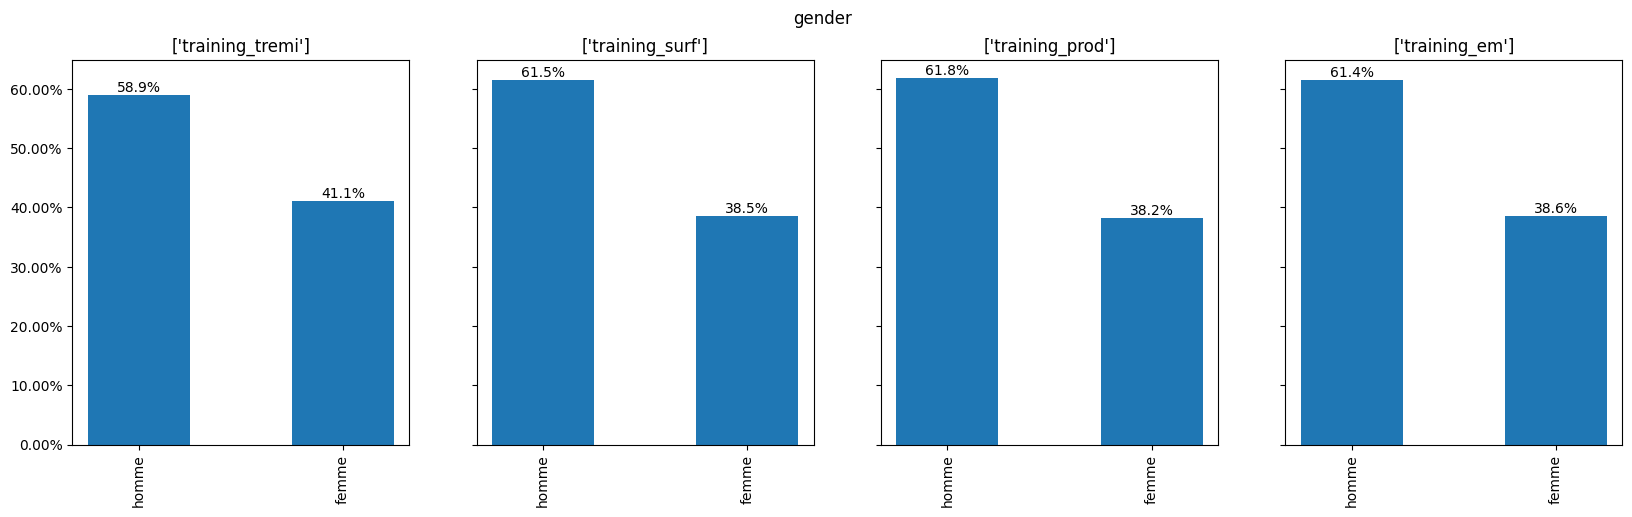

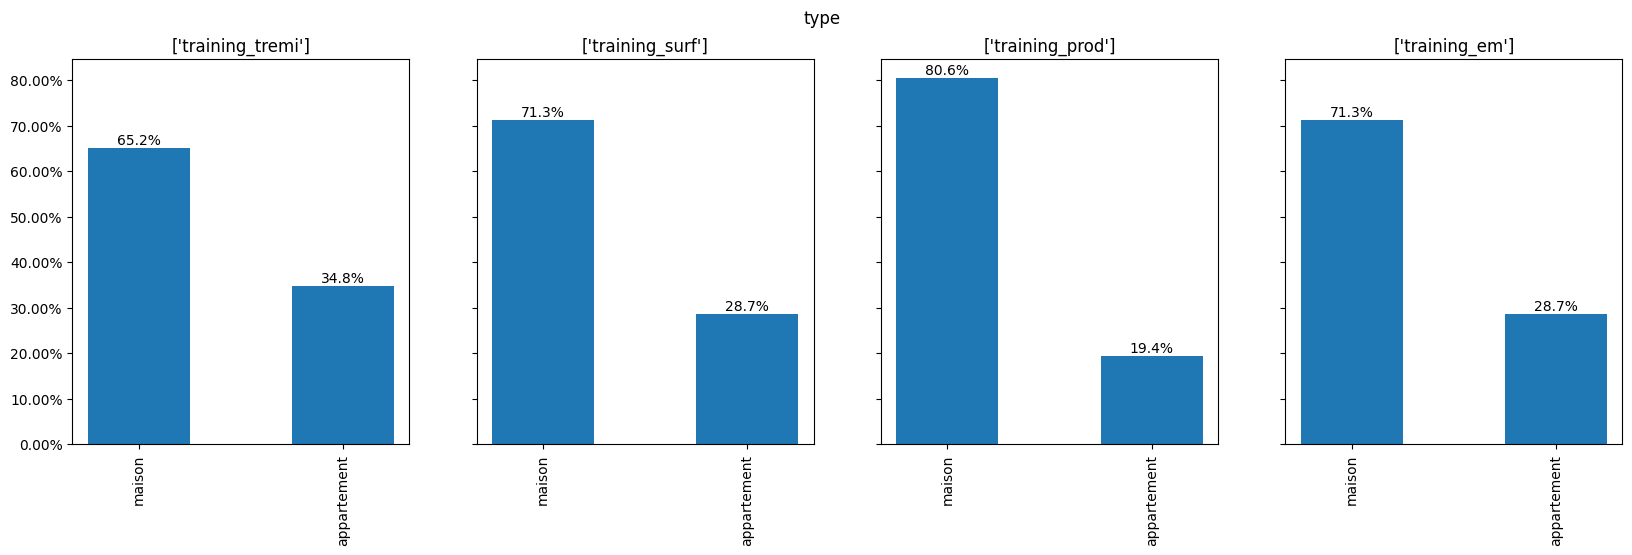

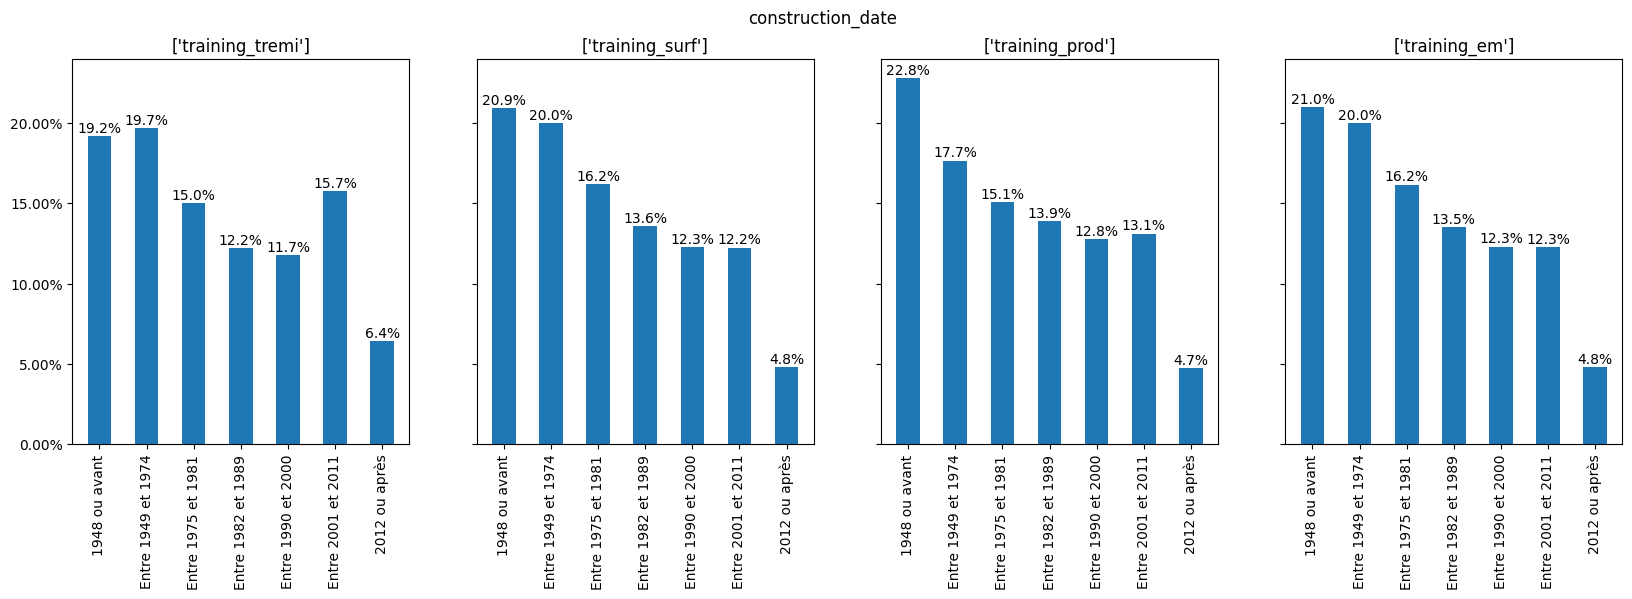

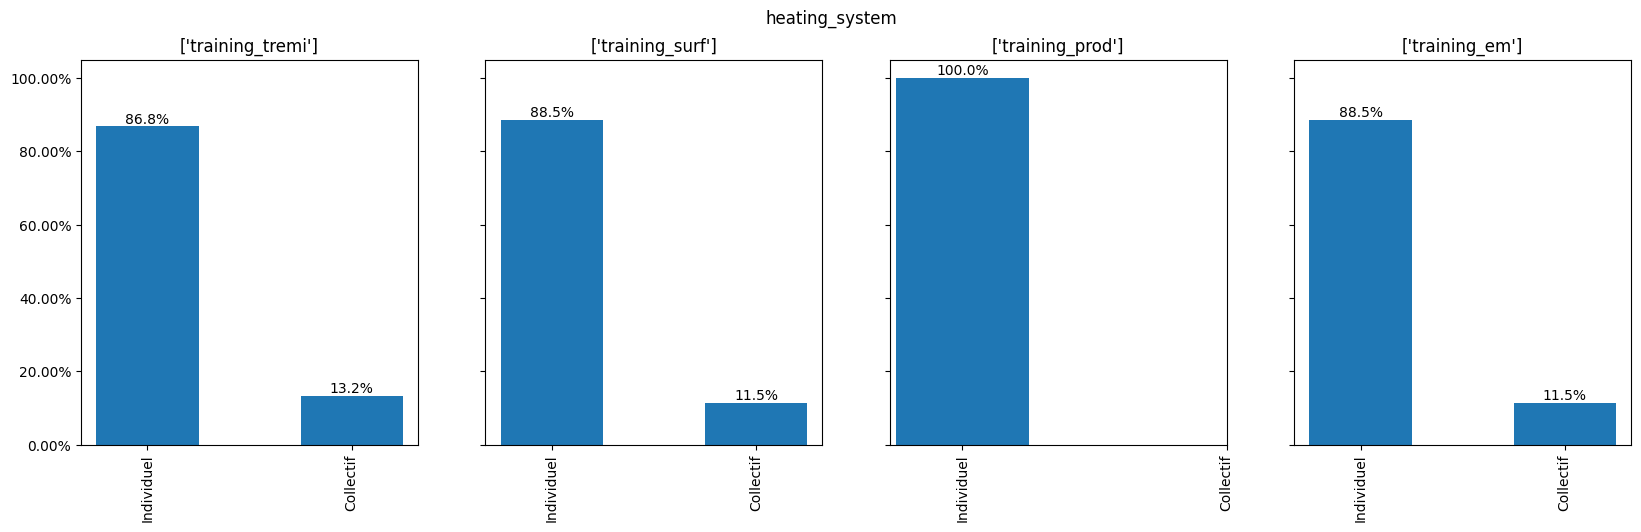

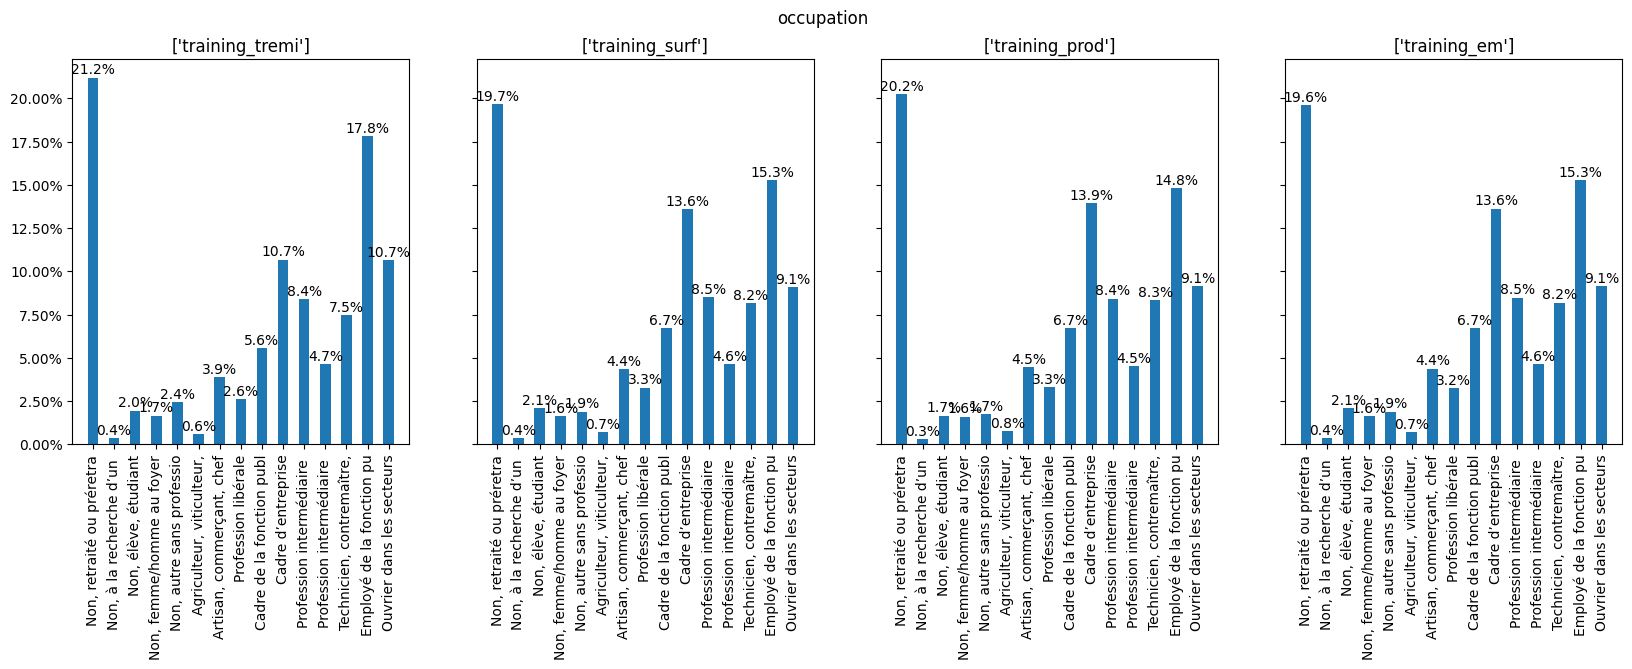

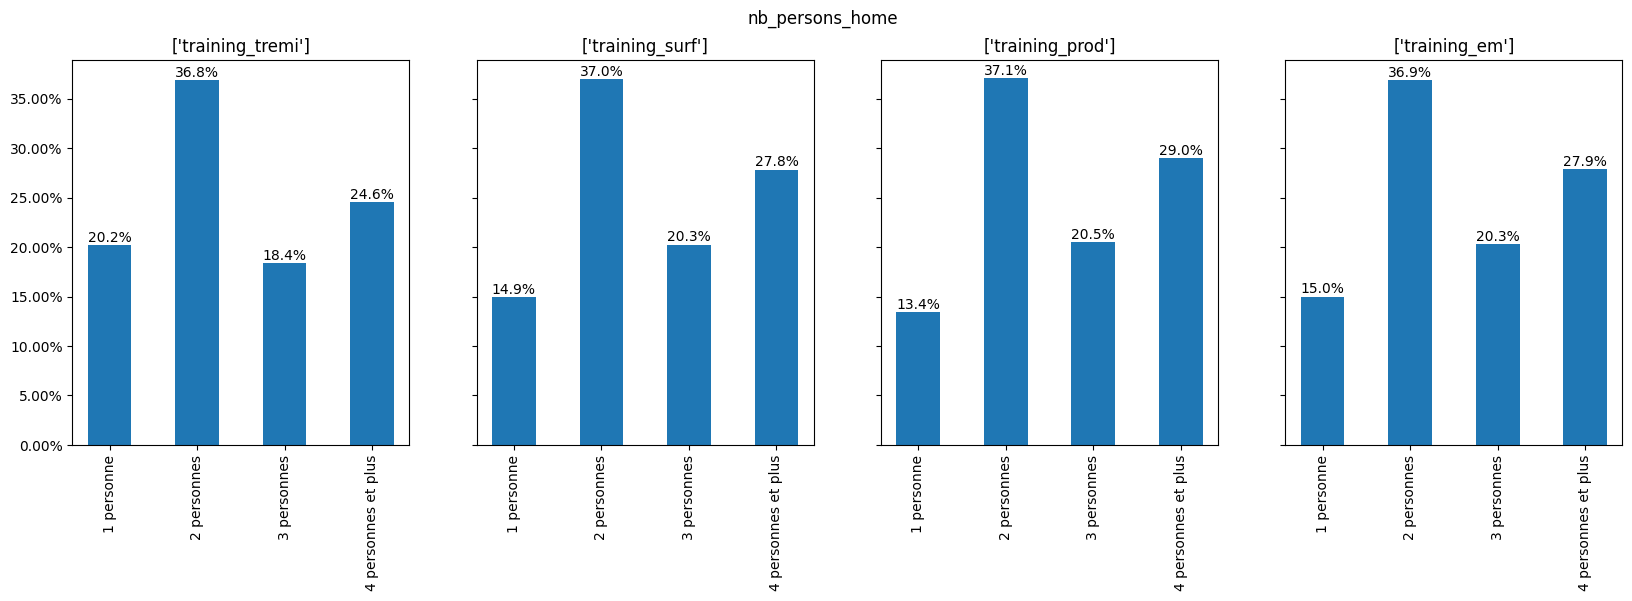

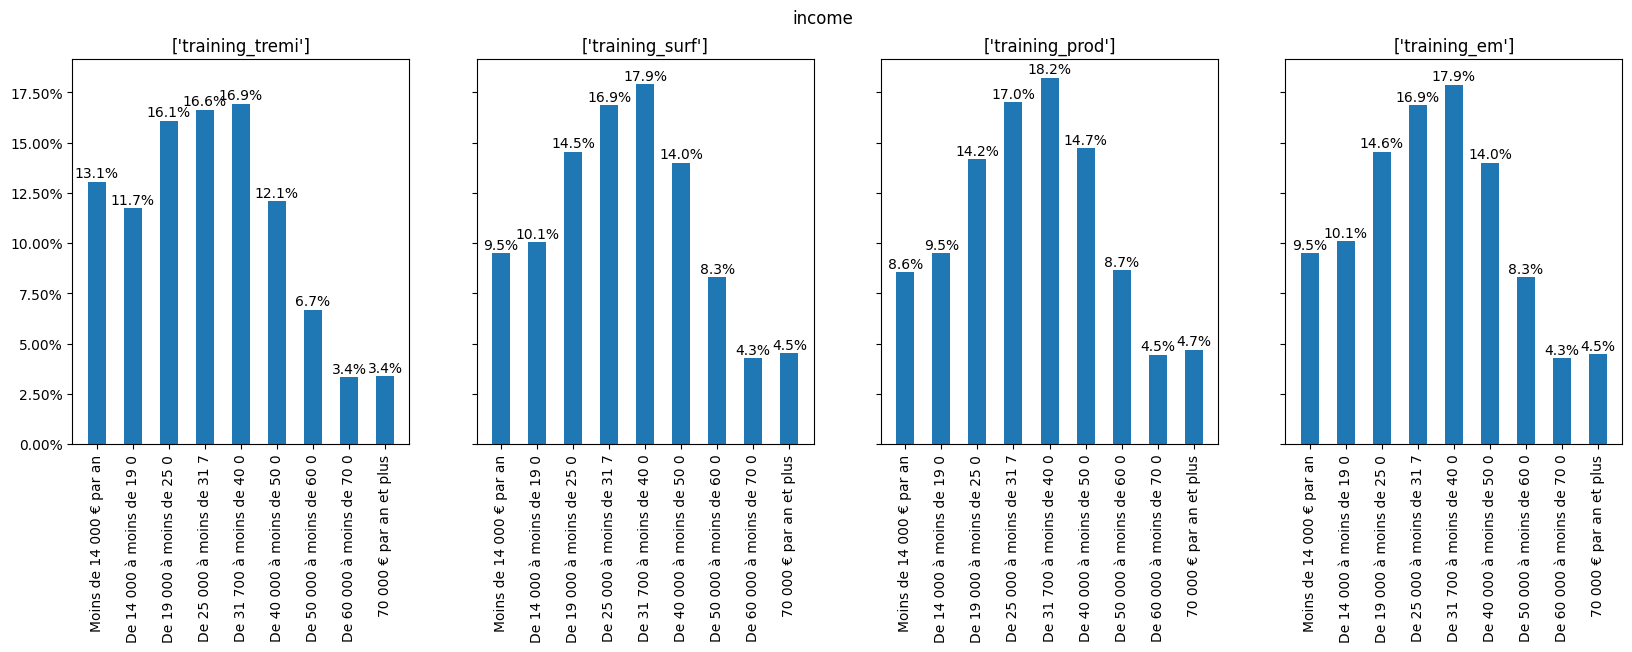

In [6]:
dfs = [training_tremi, training_surf, training_prod, training_em]
compare_repartition(dfs, dictionary, 'gender')
compare_repartition(dfs, dictionary, 'type')
compare_repartition(dfs, dictionary, 'construction_date')
compare_repartition(dfs, dictionary, 'heating_system')
compare_repartition(dfs, dictionary, 'occupation')
compare_repartition(dfs, dictionary, 'nb_persons_home')
compare_repartition(dfs, dictionary, 'income')

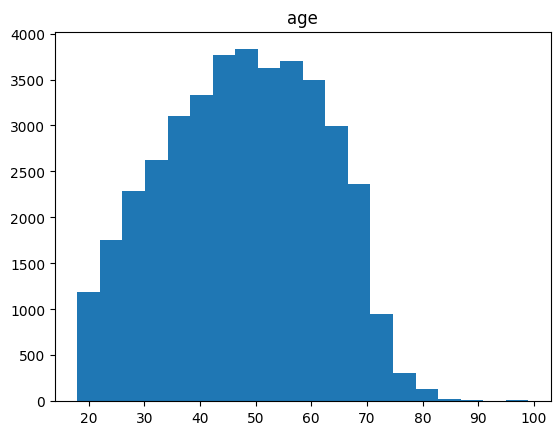

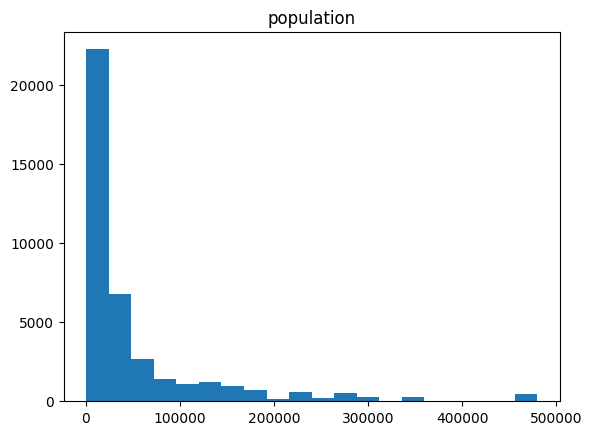

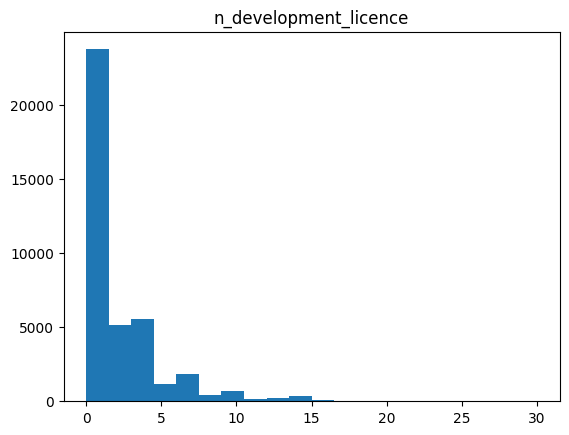

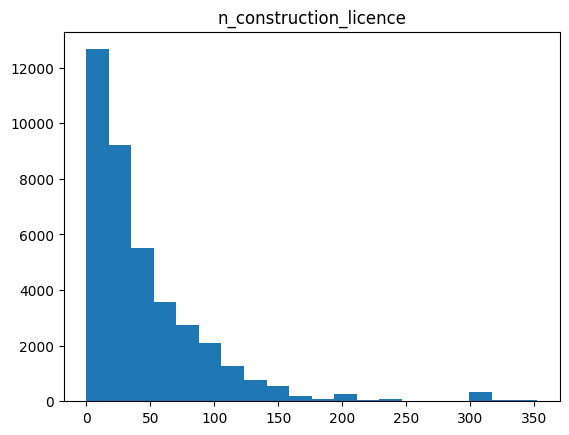

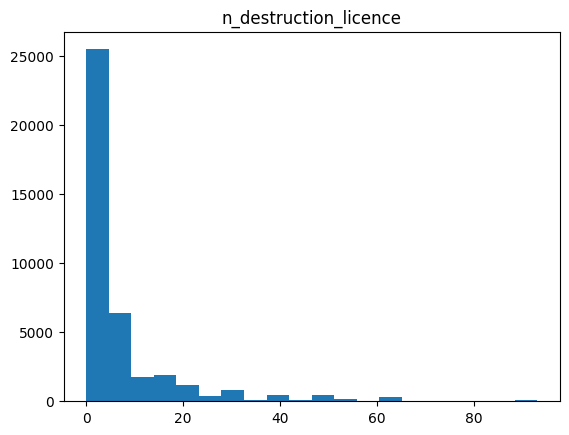

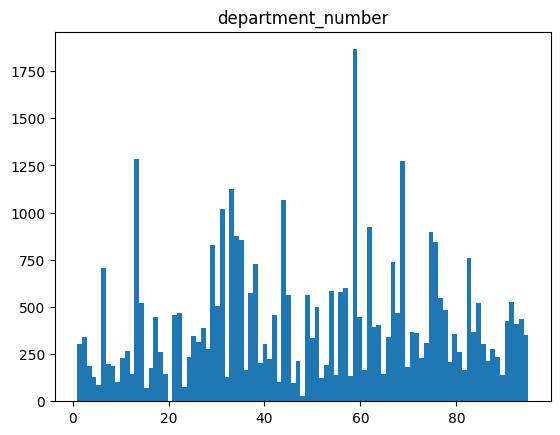

In [7]:
histo_continuous(training_tremi, 'age')
histo_continuous(training_tremi, 'population')
histo_continuous(training_tremi, 'n_development_licence')
histo_continuous(training_tremi, 'n_construction_licence')
histo_continuous(training_tremi, 'n_destruction_licence')
histo_continuous(training_tremi, 'department_number', 95)

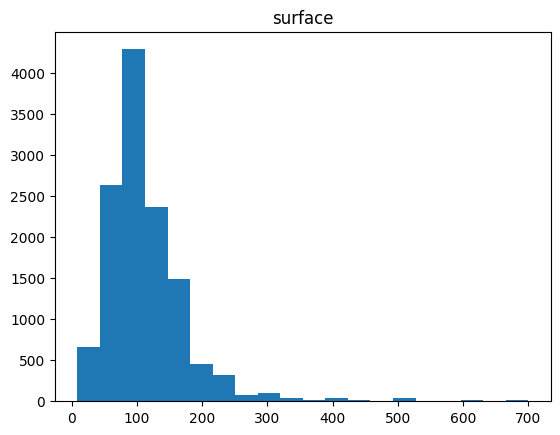

c:\Users\arocheteau\OneDrive - ASI\Documents\1_perso\projet\datalake\notebook\pySpark\lib\show.py:77: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['%1.2f%%' % i for i in vals])


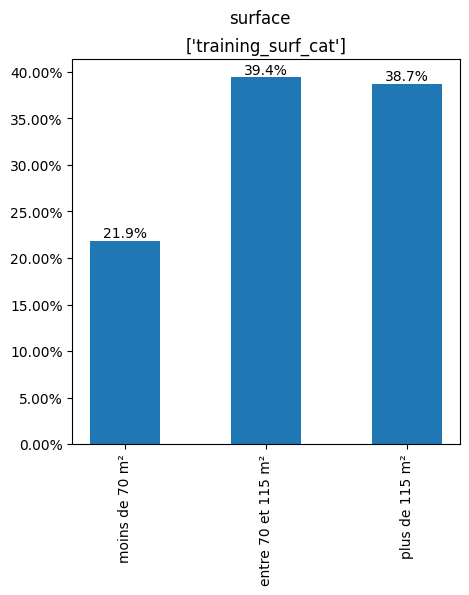

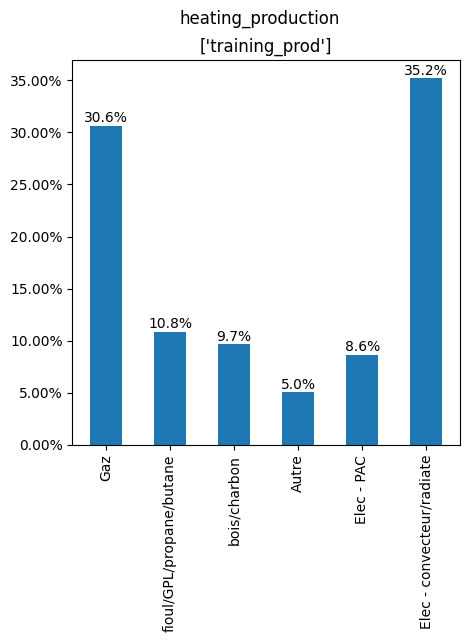

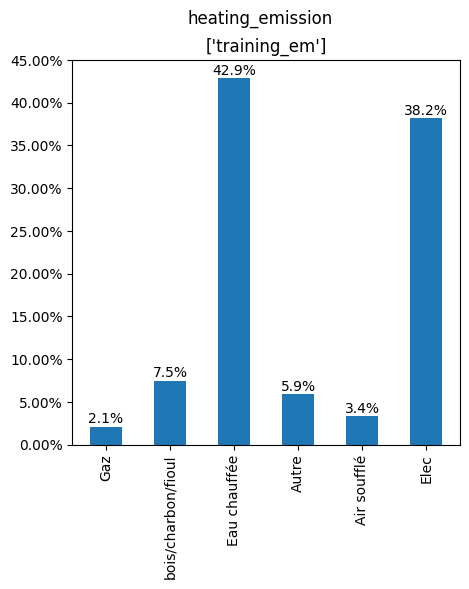

In [8]:
histo_continuous(training_surf, 'surface')
training_surf_cat = training_surf.withColumn(
    'surface',
    F.when(F.col('surface') <= 70, 0)
    .when((F.col('surface') > 70) & (F.col('surface') <= 115), 1)
    .otherwise(2)
)
compare_repartition([training_surf_cat], dictionary, 'surface')
compare_repartition([training_prod], dictionary, 'heating_production')
compare_repartition([training_em], dictionary, 'heating_emission')